<a href="https://colab.research.google.com/github/mcampb188/Stress-Detection-in-PINN-Model/blob/main/Stress_Detection_in_PINN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload WESAD dataset & start prepping


*   Clean, prepare and pre-process data
*   Define labels and null values removed
*   Begin feature extraction



## Download necessary packages for data processing.


In [ ]:
!pip install pandas
!pip install numpy scipy scikit-learn
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import glob
import os
import scipy.io as sio


## Upload the WESAD dataset from the Kaggle site.

In [ ]:
from google.colab import userdata

# Set up Kaggle API credentials as environment variables for the shell
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Use the environment variables in the shell command
!export KAGGLE_USERNAME=$KAGGLE_USERNAME && export KAGGLE_KEY=$KAGGLE_KEY && kaggle datasets download -d mohamedasem318/wesad-full-dataset -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/mohamedasem318/wesad-full-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.43G/2.43G [00:20<00:00, 115MB/s] 
100% 2.43G/2.43G [00:20<00:00, 126MB/s]


## Data cleaning

#### Chest had more available data than wrist - will continue to use this moving forward.
#### First checking how many null variables are present. From here I will determine whether to remove them or impute.



In [ ]:
# Review wrist and chest data

import pickle
import numpy as np
import glob
import os
import scipy.io as sio

# Check files in the WESAD FOLDER
wesad_dir = '/content/data/WESAD/'
subject_dirs = glob.glob(os.path.join(wesad_dir, 'S*'))

# Sampling one .pkl file
if subject_dirs:
    sample_subject_dir = subject_dirs[0]
    pkl_files = glob.glob(os.path.join(sample_subject_dir, '*.pkl'))
    if pkl_files:
        sample_file = pkl_files[0]
        print(f"Loading and examining file: {sample_file}")

        with open(sample_file, 'rb') as f:
            data = pickle.load(f, encoding='latin1')

        print("\nSample data:")
        print(data.keys())

        # Review the data array types
        print("\nReview data structure:")
        for key, value in data.items():
            print(f"Key: {key}")
            if isinstance(value, dict):
                print("  Type: Dictionary")
                print("  Keys:", value.keys())

                for sub_key, sub_value in value.items():
                    print(f"    Sub-key: {sub_key}")
                    if isinstance(sub_value, np.ndarray):
                        print(f"      Type: NumPy Array")
                        print(f"      Shape: {sub_value.shape}")
                        print(f"      Data Type: {sub_value.dtype}")
                    else:
                        print(f"      Type: {type(sub_value)}")
            elif isinstance(value, np.ndarray):
                print("  Type: NumPy Array")
                print("  Shape: {value.shape}")
                print("  Data Type: {value.dtype}")
            else:
                print(f"  Type: {type(value)}")

        # sampling rates

        print("\nFinding sampling rates:")
        if 'signal' in data and isinstance(data['signal'], dict):
            if 'wrist' in data['signal'] and isinstance(data['signal']['wrist'], dict):
                if 'sampling_rate' in data['signal']['wrist']:
                     print(f"Sampling rate for wrist data: {data['signal']['wrist']['sampling_rate']}")
                else:
                    print("Sampling rate not found in 'signal' -> 'wrist'")
                for sensor, sensor_data in data['signal']['wrist'].items():
                     if isinstance(sensor_data, np.ndarray):
                         print(f"  Wrist sensor '{sensor}' data shape: {sensor_data.shape}")

            if 'chest' in data['signal'] and isinstance(data['signal']['chest'], dict):
                 if 'sampling_rate' in data['signal']['chest']:
                     print(f"Sampling rate for chest data: {data['signal']['chest']['sampling_rate']}")
                 else:
                     print("Sampling rate not found in 'signal' -> 'chest'")
                 for sensor, sensor_data in data['signal']['chest'].items():
                     if isinstance(sensor_data, np.ndarray):
                         print(f"  Chest sensor '{sensor}' data shape: {sensor_data.shape}")

        if 'label' in data and isinstance(data['label'], np.ndarray):
             print(f"\nLabel data shape: {data['label'].shape}")
             print(f"Label data unique values: {np.unique(data['label'])}")

    else:
        print("No .pkl files found in the sample folder.")
else:
    print("No subject data found in the WESAD folder.")

Loading and examining file: /content/data/WESAD/S15/S15.pkl

Sample data:
dict_keys(['signal', 'label', 'subject'])

Review data structure:
Key: signal
  Type: Dictionary
  Keys: dict_keys(['chest', 'wrist'])
    Sub-key: chest
      Type: <class 'dict'>
    Sub-key: wrist
      Type: <class 'dict'>
Key: label
  Type: NumPy Array
  Shape: {value.shape}
  Data Type: {value.dtype}
Key: subject
  Type: <class 'str'>

Finding sampling rates:
Sampling rate not found in 'signal' -> 'wrist'
  Wrist sensor 'ACC' data shape: (168064, 3)
  Wrist sensor 'BVP' data shape: (336128, 1)
  Wrist sensor 'EDA' data shape: (21008, 1)
  Wrist sensor 'TEMP' data shape: (21008, 1)
Sampling rate not found in 'signal' -> 'chest'
  Chest sensor 'ACC' data shape: (3676400, 3)
  Chest sensor 'ECG' data shape: (3676400, 1)
  Chest sensor 'EMG' data shape: (3676400, 1)
  Chest sensor 'EDA' data shape: (3676400, 1)
  Chest sensor 'Temp' data shape: (3676400, 1)
  Chest sensor 'Resp' data shape: (3676400, 1)

Label 

In [ ]:
# Count available data for wrist and chest in original data
print("Available data in original data:")

if 'signal' in data:
    if 'wrist' in data['signal']:
        print("\nWrist Data:")
        for sensor, data_array in data['signal']['wrist'].items():
            if isinstance(data_array, np.ndarray):
                print(f"  Sensor '{sensor}': {data_array.shape[0]} samples")
            else:
                print(f"  Sensor '{sensor}': Data not in expected format ({type(data_array)})")
    else:
        print("\nNo wrist data found in original data['signal'].")

    if 'chest' in data['signal']:
        print("\nChest Data:")
        for sensor, data_array in data['signal']['chest'].items():
             if isinstance(data_array, np.ndarray):
                print(f"  Sensor '{sensor}': {data_array.shape[0]} samples")
             else:
                print(f"  Sensor '{sensor}': Data not in expected format ({type(data_array)})")
    else:
        print("\nNo chest data found in original data['signal'].")
else:
    print("\nNo 'signal' key found in original data.")

if 'label' in data and isinstance(data['label'], np.ndarray):
    print(f"\nLabel data: {data['label'].shape[0]} samples")

Available data in original data:

Wrist Data:
  Sensor 'ACC': 168064 samples
  Sensor 'BVP': 336128 samples
  Sensor 'EDA': 21008 samples
  Sensor 'TEMP': 21008 samples

Chest Data:
  Sensor 'ACC': 3676400 samples
  Sensor 'ECG': 3676400 samples
  Sensor 'EMG': 3676400 samples
  Sensor 'EDA': 3676400 samples
  Sensor 'Temp': 3676400 samples
  Sensor 'Resp': 3676400 samples

Label data: 3676400 samples


In [ ]:
# Check for null values in the chest data arrays
print("\nChecking for null values in the chest data:")

if 'signal' in data and 'chest' in data['signal']:
    for sensor, data_array in data['signal']['chest'].items():
        if isinstance(data_array, np.ndarray):

            # Check for NaN values
            nan_count = np.isnan(data_array).sum()
            print(f"  Sensor '{sensor}': {nan_count} null values")
        else:
            print(f"  Sensor '{sensor}': Data not in expected format ({type(data_array)}), cannot check for nulls.")
else:
    print("Chest data not found in the 'data' dictionary.")


Checking for null values in the chest data:
  Sensor 'ACC': 0 null values
  Sensor 'ECG': 0 null values
  Sensor 'EMG': 0 null values
  Sensor 'EDA': 0 null values
  Sensor 'Temp': 0 null values
  Sensor 'Resp': 0 null values


## Data pre-processing
#### Downsample per feature, segment in 60 second windows with 50% overlap

In [ ]:
from scipy.signal import resample
import numpy as np

# Downsample data to the specified rates
ecg_desired_sampling_rate = 250  # Hz
eda_desired_sampling_rate = 8   # Hz
resp_desired_sampling_rate = 50  # Hz


downsampled_data = {}
downsampled_data['signal'] = {}
downsampled_data['label'] = data['label']

# Define original sampling rates based on typical values for WESAD dataset
original_sampling_rate_chest = 700 # Hz for chest sensors

# -- Chest Data --
if 'chest' in data['signal']:
    downsampled_data['signal']['chest'] = {}
    for sensor, sensor_data in data['signal']['chest'].items():
        if isinstance(sensor_data, np.ndarray):
            num_original_samples = sensor_data.shape[0]
            original_sampling_rate = original_sampling_rate_chest # Assuming one original sampling rate for all chest sensors

            if sensor == 'ECG':
                desired_sampling_rate = ecg_desired_sampling_rate
            elif sensor == 'EDA':
                desired_sampling_rate = eda_desired_sampling_rate
            elif sensor == 'Resp':
                desired_sampling_rate = resp_desired_sampling_rate
            else:
                # Keep original sampling rate for other chest sensors or skip
                downsampled_data['signal']['chest'][sensor] = sensor_data
                print(f"Kept original sampling rate for chest sensor '{sensor}'. Shape: {sensor_data.shape}")
                continue # Skip downsampling for other sensors

            num_desired_samples = int(num_original_samples * (desired_sampling_rate / original_sampling_rate))

             # Resample each column if it's multi-dimensional
            if sensor_data.ndim > 1:
                downsampled_sensor_data = np.zeros((num_desired_samples, sensor_data.shape[1]))
                for col in range(sensor_data.shape[1]):
                    downsampled_sensor_data[:, col] = resample(sensor_data[:, col], num_desired_samples)
            else:
                downsampled_sensor_data = resample(sensor_data, num_desired_samples)

            downsampled_data['signal']['chest'][sensor] = downsampled_sensor_data
            print(f"Downsampled chest sensor '{sensor}'. Original shape: {sensor_data.shape}, Downsampled shape: {downsampled_sensor_data.shape}")
        else:
            downsampled_data['signal']['chest'][sensor] = sensor_data


print("\nDownsampling and processing complete.")

Kept original sampling rate for chest sensor 'ACC'. Shape: (3676400, 3)
Downsampled chest sensor 'ECG'. Original shape: (3676400, 1), Downsampled shape: (1313000, 1)
Kept original sampling rate for chest sensor 'EMG'. Shape: (3676400, 1)
Downsampled chest sensor 'EDA'. Original shape: (3676400, 1), Downsampled shape: (42016, 1)
Kept original sampling rate for chest sensor 'Temp'. Shape: (3676400, 1)
Downsampled chest sensor 'Resp'. Original shape: (3676400, 1), Downsampled shape: (262600, 1)

Downsampling and processing complete.


## Labels defined & null values check again

In [ ]:
from scipy.signal import resample
import numpy as np

# Step 1: Define segmentation parameters
window_size = 60  # In seconds
overlap = 0.5 # For 50% overlap

# Step 2: Calculate window size and step size in samples
window_samples = int(window_size * desired_sampling_rate)
step_samples = int(window_samples * (1 - overlap))

segmented_data = []
segmented_labels = []

# Step 3: Identify the relevant signals (EDA, ECG, Respiration) and segment them.

relevant_signals = {
    'chest': ['ECG', 'Resp', 'EDA']
}

# Processing only the 'chest' key data
if 'signal' in downsampled_data and 'chest' in downsampled_data['signal']:
    for sensor in relevant_signals['chest']:
        if sensor in downsampled_data['signal']['chest'] and isinstance(downsampled_data['signal']['chest'][sensor], np.ndarray):
            sensor_data = downsampled_data['signal']['chest'][sensor]
            label_data = downsampled_data['label']

            num_samples = sensor_data.shape[0]

            # Iterate through data with the sliding window
            for start_sample in range(0, num_samples - window_samples + 1, step_samples):
                end_sample = start_sample + window_samples

                # Segment the sensor data
                segment = sensor_data[start_sample:end_sample]

                # Assign label to the segment & find the original label indices.
                original_chest_sampling_rate = 700 # Approximate original sampling rate
                downsampling_factor_chest = original_chest_sampling_rate / desired_sampling_rate

                # Calculate corresponding original sample indices
                original_start_sample = int(start_sample * downsampling_factor_chest)
                original_end_sample = int(end_sample * downsampling_factor_chest)

                # Ensure the original indices don't exceed the bounds of the label data
                original_end_sample = min(original_end_sample, len(label_data))
                original_start_sample = min(original_start_sample, original_end_sample)


                segment_labels_original = label_data[original_start_sample:original_end_sample]

                # Assign labels based on the provided meanings:
                # 0 = undefined, 1 = not stressed, 2 = stress, 3 = entertained, 4 = meditation, 5/6/7 = should be ignored
                if len(segment_labels_original) > 0:
                    unique_labels, counts = np.unique(segment_labels_original, return_counts=True)
                    most_frequent_label = unique_labels[np.argmax(counts)]

                    # Assign multi-class labels based on the most frequent original label
                    if most_frequent_label in [0, 1, 2, 3, 4]:
                        # Map original labels to desired output labels
                        # 0 -> 0 (undefined)
                        # 1 -> 1 (not stressed)
                        # 2 -> 2 (stressed)
                        # 3 -> 3 (entertained)
                        # 4 -> 4 (meditating)
                        mapped_label = most_frequent_label

                        segmented_data.append(segment)
                        segmented_labels.append(mapped_label)
                    else:
                        continue

                else:
                     continue
else:
    print("Downsampled data or chest signal not found.")


print(f"Total segments created: {len(segmented_data)}")
print(f"Total labels created: {len(segmented_labels)}")

# Combine segmented_data and segmented_labels

segmented_data_np = np.array(segmented_data)
segmented_labels_np = np.array(segmented_labels)

print("\nSegmentation and labeling complete.")
print(f"Shape of segmented data array: {segmented_data_np.shape}")
print(f"Shape of segmented labels array: {segmented_labels_np.shape}")

# Print the multi-class labels
unique_labels, counts = np.unique(segmented_labels_np, return_counts=True)
print("\nDistribution of multi-class labels:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} segments")

# Check for null values in the labels
null_labels_count = np.isnan(segmented_labels_np).sum()
print(f"\nNumber of null values in segmented labels: {null_labels_count}")

Total segments created: 367
Total labels created: 367

Segmentation and labeling complete.
Shape of segmented data array: (367, 3000, 1)
Shape of segmented labels array: (367,)

Distribution of multi-class labels:
Label 0: 141 segments
Label 1: 102 segments
Label 2: 46 segments
Label 3: 26 segments
Label 4: 52 segments

Number of null values in segmented labels: 0


### Edit feature extraction so that each is accounted for

In [ ]:
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import numpy as np
import pandas as pd

##Extract EDA features: mean, variance, tonic level, phasic peak counts.
def extract_eda_features_basic(eda_segment, sampling_rate=4):
    features = {}
    if eda_segment.ndim > 1:
        eda_segment = eda_segment.flatten()

    features['eda_mean'] = np.mean(eda_segment)
    features['eda_variance'] = np.var(eda_segment)

    # Smoothing data for tonic/phasic
    tonic = uniform_filter1d(eda_segment, size=int(sampling_rate*5)) # Smoothing over 5 seconds
    phasic = eda_segment - tonic

    features['eda_tonic'] = np.mean(tonic)

    # Find phasic peaks
    peaks, _ = find_peaks(phasic, height=np.std(phasic)*0.1)
    features['eda_phasic_peak_counts'] = len(peaks)

    return features

##Extract ECG features: mean, variance, and a simple measure of variability.
def extract_ecg_features_basic(ecg_segment, sampling_rate=4):
    features = {}
    if ecg_segment.ndim > 1:
        ecg_segment = ecg_segment.flatten()

    features['ecg_mean'] = np.mean(ecg_segment)
    features['ecg_variance'] = np.var(ecg_segment)
    features['ecg_std'] = np.std(ecg_segment)

    return features

##Extract Respiration features: mean, variance, and amplitude.
def extract_respiration_features_basic(resp_segment, sampling_rate=4):
    features = {}
    if resp_segment.ndim > 1:
        resp_segment = resp_segment.flatten()

    features['resp_mean'] = np.mean(resp_segment)
    features['resp_variance'] = np.var(resp_segment)
    features['resp_amplitude_std'] = np.std(resp_segment)

    return features

# Redefining from previous steps
window_size = 60  # In seconds
overlap = 0.5 # For 50% overlap
desired_sampling_rate = 4 # In Hz

# Step 2: Calculate window size again
window_samples = int(window_size * desired_sampling_rate)
step_samples = int(window_samples * (1 - overlap))

# Initialize dictionaries to store segmented data and labels per sensor type
segmented_data_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}
segmented_labels_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}

# Step 3: Re-segment data and store by sensor type
relevant_signals = {
    'chest': ['ECG', 'Resp', 'EDA']
}

if 'signal' in downsampled_data and 'chest' in downsampled_data['signal']:
    for sensor in relevant_signals['chest']:
        if sensor in downsampled_data['signal']['chest'] and isinstance(downsampled_data['signal']['chest'][sensor], np.ndarray):
            sensor_data = downsampled_data['signal']['chest'][sensor]
            label_data = downsampled_data['label']

            num_samples = sensor_data.shape[0]

            # Iterate through data with the sliding window
            for start_sample in range(0, num_samples - window_samples + 1, step_samples):
                end_sample = start_sample + window_samples

                # Segment the sensor data
                segment = sensor_data[start_sample:end_sample]

                # Assign label to the segment based on the most frequent label in the original data window
                original_chest_sampling_rate = 700
                downsampling_factor_chest = original_chest_sampling_rate / desired_sampling_rate

                original_start_sample = int(start_sample * downsampling_factor_chest)
                original_end_sample = int(end_sample * downsampling_factor_chest)

                original_end_sample = min(original_end_sample, len(label_data))
                original_start_sample = min(original_start_sample, original_end_sample)

                segment_labels_original = label_data[original_start_sample:original_end_sample]

                if len(segment_labels_original) > 0:
                    unique_labels, counts = np.unique(segment_labels_original, return_counts=True)
                    most_frequent_label = unique_labels[np.argmax(counts)]

                    # Assign multi-class labels (0-4), ignore 5, 6, 7
                    if most_frequent_label in [0, 1, 2, 3, 4]:
                        mapped_label = most_frequent_label
                        segmented_data_by_sensor[sensor].append(segment)
                        segmented_labels_by_sensor[sensor].append(mapped_label)

else:
    print("Downsampled data or chest signal not found.")


print("Segmentation by sensor type complete.")
for sensor, segments in segmented_data_by_sensor.items():
    print(f"  {sensor}: {len(segments)} segments")
    if len(segments) > 0:
        print(f"    Sample segment shape: {segments[0].shape}")


# Step 4: Extract features for each segment by sensor type
extracted_features_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}

print("\nExtracting features by sensor type...")
for sensor, segments in segmented_data_by_sensor.items():
    print(f"  Extracting features for {sensor} segments...")
    for segment in segments:
        try:
            if sensor == 'ECG':
                features = extract_ecg_features_basic(segment, sampling_rate=desired_sampling_rate)
            elif sensor == 'Resp':
                features = extract_respiration_features_basic(segment, sampling_rate=desired_sampling_rate)
            elif sensor == 'EDA':
                features = extract_eda_features_basic(segment, sampling_rate=desired_sampling_rate)
            else:
                features = {}

            extracted_features_by_sensor[sensor].append(features)
        except Exception as e:
            print(f"Error extracting features for {sensor} segment: {e}")

            if sensor == 'ECG':
                 extracted_features_by_sensor[sensor].append({
                    'ecg_mean': np.nan,
                    'ecg_variance': np.nan,
                    'ecg_std': np.nan
                 })
            elif sensor == 'Resp':
                 extracted_features_by_sensor[sensor].append({
                    'resp_mean': np.nan,
                    'resp_variance': np.nan,
                    'resp_amplitude_std': np.nan
                 })
            elif sensor == 'EDA':
                 extracted_features_by_sensor[sensor].append({
                    'eda_mean': np.nan,
                    'eda_variance': np.nan,
                    'eda_tonic': np.nan,
                    'eda_phasic_peak_counts': np.nan
                 })


# Step 5: Combine features from different sensors for the same time window

num_segments_ecg = len(extracted_features_by_sensor['ECG'])
num_segments_resp = len(extracted_features_by_sensor['Resp'])
num_segments_eda = len(extracted_features_by_sensor['EDA'])

if not (num_segments_ecg == num_segments_resp and num_segments_resp == num_segments_eda):
    print(f"\nWarning: Number of segments for different sensors is not consistent (ECG: {num_segments_ecg}, Resp: {num_segments_resp}, EDA: {num_segments_eda}). Combining features might be inaccurate.")
    min_segments = min(num_segments_ecg, num_segments_resp, num_segments_eda)
    print(f"Proceeding by combining features for the minimum number of segments ({min_segments}). This might drop some segments.")
else:
    min_segments = num_segments_ecg

all_combined_features = []
combined_labels = []

print("\nCombining features...")
for i in range(min_segments):
    combined_feature_vector = {}

    # Combine features from each sensor for the current time window
    if i < num_segments_ecg:
        combined_feature_vector.update(extracted_features_by_sensor['ECG'][i])
        # label from the first sensor type's segment
        if i < len(segmented_labels_by_sensor['ECG']):
            current_label = segmented_labels_by_sensor['ECG'][i]
        else:
            current_label = np.nan # if label is missing

    if i < num_segments_resp:
        combined_feature_vector.update(extracted_features_by_sensor['Resp'][i])


    if i < num_segments_eda:
        combined_feature_vector.update(extracted_features_by_sensor['EDA'][i])


    all_combined_features.append(combined_feature_vector)
    combined_labels.append(current_label) # Use the label captured from the first sensor type


print(f"Total combined feature vectors created: {len(all_combined_features)}")
print(f"Total combined labels created: {len(combined_labels)}")

# Step 6: Create DataFrame and add labels
features_df = pd.DataFrame(all_combined_features)
features_df['label'] = combined_labels

print("\nCombined Features DataFrame:")
display(features_df.head())
print(f"\nShape of combined features DataFrame: {features_df.shape}")

# Step 7: Impute null values (if needed)
print("\nChecking for and imputing remaining null values...")
print("Null values before imputation:")
print(features_df.isnull().sum())

# Impute null values with the mean of each column
features_df.fillna(features_df.mean(), inplace=True)

print("\nNull values after imputation:")
print(features_df.isnull().sum())

print("\nFeatures DataFrame after imputation:")
display(features_df.head())

print("\nFeature Extraction and Combination Complete.")

Segmentation by sensor type complete.
  ECG: 171 segments
    Sample segment shape: (240, 1)
  Resp: 171 segments
    Sample segment shape: (240, 1)
  EDA: 171 segments
    Sample segment shape: (240, 1)

Extracting features by sensor type...
  Extracting features for ECG segments...
  Extracting features for Resp segments...
  Extracting features for EDA segments...

Combining features...
Total combined feature vectors created: 171
Total combined labels created: 171

Combined Features DataFrame:


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts,label
0,0.006460,0.089402,0.299001,0.160095,5.937844,2.436769,1.365700,0.008231,1.365910,12,0
1,-0.028707,0.081607,0.285669,-0.245070,14.131317,3.759164,1.371712,0.000042,1.371669,85,0
2,0.017170,0.132313,0.363748,-0.497213,11.102979,3.332113,1.381771,0.000034,1.381729,70,0
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64,1
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66,1



Shape of combined features DataFrame: (171, 11)

Checking for and imputing remaining null values...
Null values before imputation:
ecg_mean                  0
ecg_variance              0
ecg_std                   0
resp_mean                 0
resp_variance             0
resp_amplitude_std        0
eda_mean                  0
eda_variance              0
eda_tonic                 0
eda_phasic_peak_counts    0
label                     0
dtype: int64

Null values after imputation:
ecg_mean                  0
ecg_variance              0
ecg_std                   0
resp_mean                 0
resp_variance             0
resp_amplitude_std        0
eda_mean                  0
eda_variance              0
eda_tonic                 0
eda_phasic_peak_counts    0
label                     0
dtype: int64

Features DataFrame after imputation:


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts,label
0,0.006460,0.089402,0.299001,0.160095,5.937844,2.436769,1.365700,0.008231,1.365910,12,0
1,-0.028707,0.081607,0.285669,-0.245070,14.131317,3.759164,1.371712,0.000042,1.371669,85,0
2,0.017170,0.132313,0.363748,-0.497213,11.102979,3.332113,1.381771,0.000034,1.381729,70,0
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64,1
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66,1



Feature Extraction and Combination Complete.


## Begin feature extraction

### Only applying feature extraction to chest data

In [ ]:
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
import numpy as np
import pandas as pd

##Extract EDA features: mean, variance, tonic level, phasic peak counts.
def extract_eda_features_basic(eda_segment, sampling_rate=4):
    features = {}
    if eda_segment.ndim > 1:
        eda_segment = eda_segment.flatten()

    features['eda_mean'] = np.mean(eda_segment)
    features['eda_variance'] = np.var(eda_segment)

    # Smoothing data for tonic/phasic
    tonic = uniform_filter1d(eda_segment, size=int(sampling_rate*5)) # Smoothing over 5 seconds
    phasic = eda_segment - tonic

    features['eda_tonic'] = np.mean(tonic)

    # Find phasic peaks
    peaks, _ = find_peaks(phasic, height=np.std(phasic)*0.1)
    features['eda_phasic_peak_counts'] = len(peaks)

    return features

##Extract ECG features: mean, variance, and a simple measure of variability.
def extract_ecg_features_basic(ecg_segment, sampling_rate=4):
    features = {}
    if ecg_segment.ndim > 1:
        ecg_segment = ecg_segment.flatten()

    features['ecg_mean'] = np.mean(ecg_segment)
    features['ecg_variance'] = np.var(ecg_segment)
    features['ecg_std'] = np.std(ecg_segment)

    return features

##Extract Respiration features: mean, variance, and amplitude.
def extract_respiration_features_basic(resp_segment, sampling_rate=4):
    features = {}
    if resp_segment.ndim > 1:
        resp_segment = resp_segment.flatten()

    features['resp_mean'] = np.mean(resp_segment)
    features['resp_variance'] = np.var(resp_segment)
    features['resp_amplitude_std'] = np.std(resp_segment)

    return features

# Ensure segmented_data_by_sensor and segmented_labels_by_sensor are defined
# (They should be populated by the preceding data segmentation step (cell 9abc93cf))
if 'segmented_data_by_sensor' not in globals() or 'segmented_labels_by_sensor' not in globals():
    print("Warning: 'segmented_data_by_sensor' or 'segmented_labels_by_sensor' not found. "
          "Please ensure the data segmentation cell (9abc93cf) has been executed.")
    segmented_data_by_sensor = {'ECG': [], 'Resp': [], 'EDA': []}
    segmented_labels_by_sensor = {'ECG': [], 'Resp': [], 'EDA': []}


# Extract features for chest ECG segments
ecg_segments = segmented_data_by_sensor.get('ECG', [])
print(f"Extracting basic features for {len(ecg_segments)} chest ECG segments...")
ecg_features = []
for i, segment in enumerate(ecg_segments):
    try:
        features = extract_ecg_features_basic(segment, sampling_rate=desired_sampling_rate)
        ecg_features.append(features)
    except Exception as e:
        print(f"Error extracting chest ECG basic features for segment {i}: {e}")
        ecg_features.append({
            'ecg_mean': np.nan,
            'ecg_variance': np.nan,
            'ecg_std': np.nan
        })

# Extract features for chest Respiration segments
resp_segments = segmented_data_by_sensor.get('Resp', [])
print(f"Extracting basic features for {len(resp_segments)} chest Respiration segments...")
resp_features = []
for i, segment in enumerate(resp_segments):
    try:
        features = extract_respiration_features_basic(segment, sampling_rate=desired_sampling_rate)
        resp_features.append(features)
    except Exception as e:
        print(f"Error extracting chest Respiration basic features for segment {i}: {e}")
        resp_features.append({
            'resp_mean': np.nan,
            'resp_variance': np.nan,
            'resp_amplitude_std': np.nan
        })

# Extract features for chest EDA segments
eda_segments = segmented_data_by_sensor.get('EDA', [])
print(f"Extracting basic features for {len(eda_segments)} chest EDA segments...")
eda_features = []
for i, segment in enumerate(eda_segments):
    try:
        features = extract_eda_features_basic(segment, sampling_rate=desired_sampling_rate)
        eda_features.append(features)
    except Exception as e:
        print(f"Error extracting chest EDA basic features for segment {i}: {e}")
        eda_features.append({
            'eda_mean': np.nan,
            'eda_variance': np.nan,
            'eda_tonic': np.nan,
            'eda_phasic_peak_counts': np.nan
        })


# Combine features from different sensors based on the minimum number of segments
min_segments = min(len(ecg_features), len(resp_features), len(eda_features))
all_features = []
for i in range(min_segments):
    combined_feature_vector = {}
    combined_feature_vector.update(ecg_features[i])
    combined_feature_vector.update(resp_features[i])
    combined_feature_vector.update(eda_features[i])
    all_features.append(combined_feature_vector)


print(f"Total features extracted: {len(all_features)}")

# Convert the list of dictionaries to a pandas DataFrame
features_df = pd.DataFrame(all_features)

print("\nBasic Feature Extraction Complete.")
display(features_df.head())
print(f"\nShape of features DataFrame: {features_df.shape}")

# Add the labels to the DataFrame - ensure labels match the number of combined features
# Check if segmented_labels_by_sensor['ECG'] is not empty before attempting to slice
if segmented_labels_by_sensor.get('ECG') and len(segmented_labels_by_sensor['ECG']) >= len(features_df):
    features_df['label'] = segmented_labels_by_sensor['ECG'][:len(features_df)]
else:
    print("Warning: Labels for features_df could not be assigned, likely due to missing or insufficient segmented_labels_by_sensor['ECG'] data.")
    features_df['label'] = np.nan # Assign NaN or a placeholder if labels are unavailable


print("\nFeatures DataFrame with labels:")
display(features_df.head())
print(f"\nShape of features DataFrame with labels: {features_df.shape}")

Extracting basic features for 171 chest ECG segments...
Extracting basic features for 171 chest Respiration segments...
Extracting basic features for 171 chest EDA segments...
Total features extracted: 171

Basic Feature Extraction Complete.


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts
0,0.006460,0.089402,0.299001,0.160095,5.937844,2.436769,1.365700,0.008231,1.365910,12
1,-0.028707,0.081607,0.285669,-0.245070,14.131317,3.759164,1.371712,0.000042,1.371669,85
2,0.017170,0.132313,0.363748,-0.497213,11.102979,3.332113,1.381771,0.000034,1.381729,70
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66



Shape of features DataFrame: (171, 10)

Features DataFrame with labels:


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts,label
0,0.006460,0.089402,0.299001,0.160095,5.937844,2.436769,1.365700,0.008231,1.365910,12,0
1,-0.028707,0.081607,0.285669,-0.245070,14.131317,3.759164,1.371712,0.000042,1.371669,85,0
2,0.017170,0.132313,0.363748,-0.497213,11.102979,3.332113,1.381771,0.000034,1.381729,70,0
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64,1
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66,1



Shape of features DataFrame with labels: (171, 11)


#### Show examples of extracted features

In [ ]:
# Filter the DataFrame to show rows where the label is not 0
non_zero_labels_df = features_df[features_df['label'] != 0]

# Display the first few rows of the filtered DataFrame
print("Examples of extracted features for segments with labels other than 0:")
if not non_zero_labels_df.empty:
    display(non_zero_labels_df.head())
else:
    print("No segments found with labels other than 0 in the features_df DataFrame.")

Examples of extracted features for segments with labels other than 0:


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts,label
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64,1
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66,1
5,-0.006031,0.132337,0.363782,-0.326114,10.571401,3.251369,1.408200,0.000037,1.408175,64,1
6,0.012194,0.074609,0.273147,1.101551,19.432121,4.408188,1.418376,0.000044,1.418339,52,1
7,-0.003071,0.073347,0.270827,0.229675,30.833342,5.552778,1.430399,0.000050,1.430351,59,1


# Baseline Models

* Logistic Regression
* Random Forest Classifier
* XGBoost

## Train Features on Baseline Models


#### Logistic Regression Model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Assuming 'features_df' is your DataFrame with basic features and 'label' column

# Separate features (X) and labels (y)
X = features_df.drop('label', axis=1)
y = features_df['label']

# Split data into training and testing sets
# Check if there are enough samples for splitting
if len(X) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
else:
    print("Not enough data to train the model.")

Accuracy: 0.5714285714285714

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.86      0.62        14
           1       0.80      1.00      0.89         8
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         5

    accuracy                           0.57        35
   macro avg       0.26      0.37      0.30        35
weighted avg       0.37      0.57      0.45        35


Confusion Matrix:
[[12  2  0  0  0]
 [ 0  8  0  0  0]
 [ 5  0  0  0  0]
 [ 3  0  0  0  0]
 [ 5  0  0  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

#### Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming 'features_df' is available from previous steps

# Separate features (X) and labels (y)
X = features_df.drop('label', axis=1)
y = features_df['label']

# Split data into training and testing sets
# Check if there are enough samples for splitting
if len(X) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize and train the Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
else:
     print("Not enough data to train the model.")


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       0.50      0.60      0.55         5

    accuracy                           0.80        35
   macro avg       0.82      0.85      0.83        35
weighted avg       0.81      0.80      0.80        35


Confusion Matrix:
[[9 2 0 0 3]
 [0 8 0 0 0]
 [0 0 5 0 0]
 [0 0 0 3 0]
 [2 0 0 0 3]]


#### XGBoost Model

In [ ]:
# Display the first few rows of the features_df DataFrame to show examples of the extracted features.
if 'features_df' in locals():
    print("Displaying the first 5 rows of the features_df DataFrame:")
    display(features_df.head())
else:
    print("The 'features_df' DataFrame is not available. Please run the data processing and feature extraction steps first.")

Displaying the first 5 rows of the features_df DataFrame:


,ecg_mean,ecg_variance,ecg_std,resp_mean,resp_variance,resp_amplitude_std,eda_mean,eda_variance,eda_tonic,eda_phasic_peak_counts,label
0,0.006460,0.089402,0.299001,0.160095,5.937844,2.436769,1.365700,0.008231,1.365910,12,0
1,-0.028707,0.081607,0.285669,-0.245070,14.131317,3.759164,1.371712,0.000042,1.371669,85,0
2,0.017170,0.132313,0.363748,-0.497213,11.102979,3.332113,1.381771,0.000034,1.381729,70,0
3,0.016961,0.068439,0.261609,0.490759,2.660999,1.631257,1.393311,0.000065,1.393267,64,1
4,-0.015815,0.068661,0.262032,-0.012261,3.140748,1.772216,1.402038,0.000033,1.402001,66,1


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Separate features (X) and labels (y)
X = features_df.drop('label', axis=1)
y = features_df['label']

# Split data into training and testing sets
if len(X) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # train the XGBoost model
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), eval_metric='mlogloss', use_label_encoder=False, random_state=42)
    model.fit(X_train, y_train)

    # Make prediction on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
else:
     print("Not enough data - try again.")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5

    accuracy                           0.94        35
   macro avg       0.96      0.97      0.96        35
weighted avg       0.95      0.94      0.94        35


Confusion Matrix:
[[12  2  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0  5]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:10:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Load & consolidate WESAD data for neural network

In [ ]:
import pickle
import numpy as np
import glob
import os

# 1. Initialize an empty list to store all subjects' data
all_subjects_data = []

# Define the directory containing WESAD subject folders
wesad_dir = '/content/data/WESAD/'
subject_dirs = glob.glob(os.path.join(wesad_dir, 'S*'))

# 2. Iterate through each subject directory
for subject_dir in subject_dirs:
    # 3. Construct the full path to the .pkl file for the current subject
    pkl_files = glob.glob(os.path.join(subject_dir, '*.pkl'))
    if pkl_files:
        subject_file = pkl_files[0]

        try:
            # 4. Open and load each .pkl file
            with open(subject_file, 'rb') as f:
                data = pickle.load(f, encoding='latin1')

            # 5. Extract 'chest' signals and 'label' array
            chest_signals = data['signal']['chest']
            labels = data['label']

            # 6. Store extracted data and append to the list
            all_subjects_data.append({
                'chest_signals': chest_signals,
                'labels': labels
            })
        except Exception as e:
            print(f"Error loading or processing {subject_file}: {e}")

# 7. Print total data loaded and display details of first few rows
print(f"Total subjects successfully loaded: {len(all_subjects_data)}")

if all_subjects_data:
    first_subject = all_subjects_data[0]
    print("\nDetails for the first loaded subject:")
    print(f"  Keys of chest_signals: {first_subject['chest_signals'].keys()}")
    print(f"  Shape of labels array: {first_subject['labels'].shape}")
else:
    print("No subjects were loaded.")

Total subjects successfully loaded: 15

Details for the first loaded subject:
  Keys of chest_signals: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
  Shape of labels array: (3676400,)


### Downsample and Segment Subjects' Data

#### Details:
Process the data by applying desired downsampling rates for ECG, EDA, and Respiration signals. Then, segment each downsampled signal into 60-second windows with 50% overlap. Assign multi-class labels (0-4) to each segment based on the most frequent original label within that window.


In [ ]:
import numpy as np
from scipy.signal import resample

# 1. Initialize empty dictionaries to store segmented data and labels from all subjects
all_segmented_data_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}
all_segmented_labels_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}

# 2. Define the target downsampling rates and original sampling rate
ecg_target_sampling_rate = 125  # Hz
eda_target_sampling_rate = 4  # Hz
resp_target_sampling_rate = 25  # Hz
original_chest_sampling_rate = 700 # Hz for all chest sensors in original data

# 3. Define segmentation parameters
window_size = 30  # In seconds
overlap = 0.5     # For 50% overlap

# 4. Iterate through each subject_data dictionary in the all_subjects_data list
for subject_idx, subject_data in enumerate(all_subjects_data):
    print(f"Processing subject {subject_idx + 1}/{len(all_subjects_data)}...")
    current_chest_signals = subject_data['chest_signals']
    original_labels = subject_data['labels']

    subject_downsampled_data = {'chest': {}}

    # 4.c. Downsample each sensor signal for the current subject
    for sensor_name, sensor_data_array in current_chest_signals.items():
        if not isinstance(sensor_data_array, np.ndarray):
            # print(f"  Skipping non-array data for sensor {sensor_name}")
            continue

        num_original_samples = sensor_data_array.shape[0]
        current_original_sampling_rate = original_chest_sampling_rate # All chest sensors start at 700 Hz

        target_sampling_rate = current_original_sampling_rate # Default to original if not specified for segmentation

        if sensor_name == 'ECG':
            target_sampling_rate = ecg_target_sampling_rate
        elif sensor_name == 'EDA':
            target_sampling_rate = eda_target_sampling_rate
        elif sensor_name == 'Resp':
            target_sampling_rate = resp_target_sampling_rate
        # For 'ACC', 'EMG', 'Temp', target_sampling_rate remains current_original_sampling_rate (700 Hz)

        num_desired_samples = int(num_original_samples * (target_sampling_rate / current_original_sampling_rate))

        if num_desired_samples == 0:
            # print(f"  Warning: Downsampled {sensor_name} would have 0 samples, skipping.")
            continue

        # Resample each column if it's multi-dimensional (e.g., ACC) or a single column
        if sensor_data_array.ndim > 1:
            downsampled_sensor_data = np.zeros((num_desired_samples, sensor_data_array.shape[1]))
            for col in range(sensor_data_array.shape[1]):
                downsampled_sensor_data[:, col] = resample(sensor_data_array[:, col], num_desired_samples)
        else:
            downsampled_sensor_data = resample(sensor_data_array, num_desired_samples)

        subject_downsampled_data['chest'][sensor_name] = downsampled_sensor_data

    # 4.d. Segment relevant sensors and assign labels for the current subject
    relevant_sensors_for_segmentation = ['ECG', 'Resp', 'EDA']
    for sensor_to_segment in relevant_sensors_for_segmentation:
        if sensor_to_segment not in subject_downsampled_data['chest']:
            print(f"  Warning: {sensor_to_segment} data not available for segmentation for this subject.")
            continue

        downsampled_sensor_data = subject_downsampled_data['chest'][sensor_to_segment]
        num_downsampled_samples = downsampled_sensor_data.shape[0]

        # Determine the effective sampling rate for this sensor to calculate window_samples
        current_segmentation_sampling_rate = 0
        if sensor_to_segment == 'ECG':
            current_segmentation_sampling_rate = ecg_target_sampling_rate
        elif sensor_to_segment == 'EDA':
            current_segmentation_sampling_rate = eda_target_sampling_rate
        elif sensor_to_segment == 'Resp':
            current_segmentation_sampling_rate = resp_target_sampling_rate

        if current_segmentation_sampling_rate == 0:
            print(f"  Error: Could not determine segmentation sampling rate for {sensor_to_segment}. Skipping segmentation.")
            continue

        # Calculate window and step size in samples based on the sensor's desired sampling rate
        current_window_samples = int(window_size * current_segmentation_sampling_rate)
        current_step_samples = int(current_window_samples * (1 - overlap))

        if current_window_samples == 0 or current_step_samples == 0:
            print(f"  Warning: Window or step size for {sensor_to_segment} is zero, skipping segmentation.")
            continue


        for start_sample_downsampled in range(0, num_downsampled_samples - current_window_samples + 1, current_step_samples):
            end_sample_downsampled = start_sample_downsampled + current_window_samples

            segment = downsampled_sensor_data[start_sample_downsampled:end_sample_downsampled]

            # Map downsampled segment indices back to original label indices
            sampling_rate_ratio = original_chest_sampling_rate / current_segmentation_sampling_rate

            original_start_sample_for_label = int(start_sample_downsampled * sampling_rate_ratio)
            original_end_sample_for_label = int(end_sample_downsampled * sampling_rate_ratio)

            # Ensure original_end_sample_for_label does not exceed original_labels length
            original_end_sample_for_label = min(original_end_sample_for_label, len(original_labels))
            original_start_sample_for_label = min(original_start_sample_for_label, original_end_sample_for_label) # Ensure start is not after end

            if original_start_sample_for_label >= original_end_sample_for_label:
                continue # Skip if no valid range for labels

            segment_labels_original = original_labels[original_start_sample_for_label:original_end_sample_for_label]

            # Assign label based on the most frequent among 0-4, ignoring 5, 6, 7
            valid_labels = segment_labels_original[(segment_labels_original >= 0) & (segment_labels_original <= 4)]

            if len(valid_labels) > 0:
                unique_labels, counts = np.unique(valid_labels, return_counts=True)
                most_frequent_label = unique_labels[np.argmax(counts)]

                all_segmented_data_by_sensor[sensor_to_segment].append(segment)
                all_segmented_labels_by_sensor[sensor_to_segment].append(most_frequent_label)
            else:
                # If no valid labels (0-4) are found, skip this segment
                continue

print("\n--- All Subjects Processing Complete ---")

# 5. Print the total number of segments created for each sensor type
print("\nTotal segments created per sensor type:")
for sensor, segments_list in all_segmented_data_by_sensor.items():
    print(f"  {sensor}: {len(segments_list)} segments")
    if len(segments_list) > 0:
        print(f"    Sample segment shape: {segments_list[0].shape}")

# 6. Print the distribution of multi-class labels across all combined segments
print("\nDistribution of multi-class labels across all combined segments:")
all_labels_combined_for_report = []
for sensor in relevant_sensors_for_segmentation:
    all_labels_combined_for_report.extend(all_segmented_labels_by_sensor[sensor])

if len(all_labels_combined_for_report) > 0:
    unique_labels, counts = np.unique(all_labels_combined_for_report, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"  Label {label}: {count} segments")
else:
    print("  No segments with valid labels were created.")

Processing subject 1/15...
Processing subject 2/15...
Processing subject 3/15...
Processing subject 4/15...
Processing subject 5/15...
Processing subject 6/15...
Processing subject 7/15...
Processing subject 8/15...
Processing subject 9/15...
Processing subject 10/15...
Processing subject 11/15...
Processing subject 12/15...
Processing subject 13/15...
Processing subject 14/15...
Processing subject 15/15...

--- All Subjects Processing Complete ---

Total segments created per sensor type:
  ECG: 5701 segments
    Sample segment shape: (3750, 1)
  Resp: 5701 segments
    Sample segment shape: (750, 1)
  EDA: 5701 segments
    Sample segment shape: (120, 1)

Distribution of multi-class labels across all combined segments:
  Label 0: 8115 segments
  Label 1: 3519 segments
  Label 2: 2001 segments
  Label 3: 1113 segments
  Label 4: 2355 segments


# Neural Network Baseline

## Prepare Neural Network Data

### Details:
Extract and combine the segmented signal data (ECG, Respiration, and EDA) from `segmented_data_by_sensor`. Standardize the signal data using `StandardScaler` and reshape for the 1D-CNN input. Finally, split the combined dataset into training, validation, and test sets.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Convert segmented data to NumPy arrays
X_ecg = np.array(all_segmented_data_by_sensor['ECG'])
X_resp = np.array(all_segmented_data_by_sensor['Resp'])
X_eda = np.array(all_segmented_data_by_sensor['EDA'])

# Ensure all arrays have the same number of segments
min_segments = min(X_ecg.shape[0], X_resp.shape[0], X_eda.shape[0])
X_ecg = X_ecg[:min_segments]
X_resp = X_resp[:min_segments]
X_eda = X_eda[:min_segments]
# Create y labels
y_labels = np.array(all_segmented_labels_by_sensor['ECG']) # Assuming labels are consistent across sensors
y_labels = y_labels[:min_segments]


# ECG Standardization
num_segments_ecg, sequence_length_ecg, num_features_ecg = X_ecg.shape
scaler_ecg = StandardScaler()
X_ecg_scaled = scaler_ecg.fit_transform(X_ecg.reshape(-1, num_features_ecg)).reshape(num_segments_ecg, sequence_length_ecg, num_features_ecg)

# Respiration Standardization
num_segments_resp, sequence_length_resp, num_features_resp = X_resp.shape
scaler_resp = StandardScaler()
X_resp_scaled = scaler_resp.fit_transform(X_resp.reshape(-1, num_features_resp)).reshape(num_segments_resp, sequence_length_resp, num_features_resp)

# EDA Standardization
num_segments_eda, sequence_length_eda, num_features_eda = X_eda.shape
scaler_eda = StandardScaler()
X_eda_scaled = scaler_eda.fit_transform(X_eda.reshape(-1, num_features_eda)).reshape(num_segments_eda, sequence_length_eda, num_features_eda)


# Split into training and temporary sets (40% train, 60% temp to reduce training data)
X_train_ecg, X_temp_ecg, X_train_resp, X_temp_resp, X_train_eda, X_temp_eda, y_train, y_temp = train_test_split(
    X_ecg_scaled, X_resp_scaled, X_eda_scaled, y_labels,
    test_size=0.6, random_state=42, stratify=y_labels
)

# Split the temporary set into validation and test sets (50% val, 50% test of temp set)
X_val_ecg, X_test_ecg, X_val_resp, X_test_resp, X_val_eda, X_test_eda, y_val, y_test = train_test_split(
    X_temp_ecg, X_temp_resp, X_temp_eda, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Print/QA sizes of the datasets
print(f"Size of X_train_ecg: {X_train_ecg.shape}")
print(f"Size of X_train_resp: {X_train_resp.shape}")
print(f"Size of X_train_eda: {X_train_eda.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of X_val_ecg: {X_val_ecg.shape}")
print(f"Size of X_val_resp: {X_val_resp.shape}")
print(f"Size of X_val_eda: {X_val_eda.shape}")
print(f"Size of y_val: {y_val.shape}")
print(f"Size of X_test_ecg: {X_test_ecg.shape}")
print(f"Size of X_test_resp: {X_test_resp.shape}")
print(f"Size of X_test_eda: {X_test_eda.shape}")
print(f"Size of y_test: {y_test.shape}")


Size of X_train_ecg: (2280, 3750, 1)
Size of X_train_resp: (2280, 750, 1)
Size of X_train_eda: (2280, 120, 1)
Size of y_train: (2280,)
Size of X_val_ecg: (1710, 3750, 1)
Size of X_val_resp: (1710, 750, 1)
Size of X_val_eda: (1710, 120, 1)
Size of y_val: (1710,)
Size of X_test_ecg: (1711, 3750, 1)
Size of X_test_resp: (1711, 750, 1)
Size of X_test_eda: (1711, 120, 1)
Size of y_test: (1711,)


## Build 1D-CNN + BiLSTM Model Architecture

### Details:
Construct the neural network model. The architecture will include separate 1D-CNN layers for each modality (ECG, Respiration, EDA) to capture local patterns. The output of each 1D-CNN branch will then be fed into BiLSTM layers to capture temporal dependencies. A fusion layer will concatenate the outputs from the BiLSTM layers. The model will conclude with fully connected layers and a softmax activation function for multi-class classification (stress/non-stress).

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, concatenate, Dense
from tensorflow.keras.models import Model
import numpy as np

#1 Define input shape for each modality
sequence_length_ecg = X_train_ecg.shape[1]
sequence_length_resp = X_train_resp.shape[1]
sequence_length_eda = X_train_eda.shape[1]

input_shape_ecg = (sequence_length_ecg, 1)
input_shape_resp = (sequence_length_resp, 1)
input_shape_eda = (sequence_length_eda, 1)

#2 Create three separate Input layers
ecg_input = Input(shape=input_shape_ecg, name='ecg_input')
resp_input = Input(shape=input_shape_resp, name='resp_input')
eda_input = Input(shape=input_shape_eda, name='eda_input')

#3 Build 1D-CNN branch for ECG (reduced filters to 32)
ecg_branch = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(ecg_input)
ecg_branch = MaxPooling1D(pool_size=2, padding='same')(ecg_branch)

#4 Build 1D-CNN branch for Respiratory (reduced filters to 32)
resp_branch = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(resp_input)
resp_branch = MaxPooling1D(pool_size=2, padding='same')(resp_branch)

#5 Build 1D-CNN branch for EDA (reduced filters to 32)
eda_branch = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(eda_input)
eda_branch = MaxPooling1D(pool_size=2, padding='same')(eda_branch)

#6 Pass the output of each 1D-CNN branch through a Bidirectional(LSTM) layer (reduced LSTM units to 32)
ecg_bilstm = Bidirectional(LSTM(32, return_sequences=False))(ecg_branch)
resp_bilstm = Bidirectional(LSTM(32, return_sequences=False))(resp_branch)
eda_bilstm = Bidirectional(LSTM(32, return_sequences=False))(eda_branch)

#7 Concatenate the outputs of the three layers
fused_output = concatenate([ecg_bilstm, resp_bilstm, eda_bilstm], axis=-1)
dense_layer = Dense(128, activation='relu')(fused_output)

#8 Create the final output
num_classes = len(np.unique(y_train))
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

#10 Instantiate the Keras Model
model = Model(inputs=[ecg_input, resp_input, eda_input], outputs=output_layer)

print("Model architecture defined successfully.")
model.summary()

Model architecture defined successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_input           │ (None, 3750, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resp_input          │ (None, 750, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eda_input           │ (None, 120, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3750, 32)  │        128 │ ecg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 750, 32)   │        128 │ resp_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 120, 32)   │        128 │ eda_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1875, 32)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 375, 32)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 60, 32)    │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     16,640 │ max_pooling1d_3[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 64)        │     16,640 │ max_pooling1d_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     16,640 │ max_pooling1d_5[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
│                     │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 75,653 (295.52 KB)

 Trainable params: 75,653 (295.52 KB)

 Non-trainable params: 0 (0.00 B)

## Train Neural Network

### Details:
Use the Adam optimizer and `SparseCategoricalCrossentropy` as the loss function. Implement early stopping using `tf.keras.callbacks.EarlyStopping` to monitor the validation ROC-AUC score.

**Reasoning**:
Compile the neural network model with the key metrics and accuracy scores, then set up early stopping and train the model with the provided data.




In [ ]:
import tensorflow as tf

# 1. Compile the model
# Assuming 'model' is already defined from the previous step
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Create an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True
)

# 3. Train the model
history = model.fit(
    [X_train_ecg, X_train_resp, X_train_eda],
    y_train,
    epochs=80,
    batch_size=32,
    validation_data=(
        [X_val_ecg, X_val_resp, X_val_eda],
        y_val
    ),
    callbacks=[early_stopping]
)

print("Model compiled and training initiated.")

Epoch 1/80
 8/72 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.3617 - loss: 1.5789

KeyboardInterrupt: 

**Reasoning**:
Compile the neural network model with the specified optimizer, loss function, and metrics, then set up early stopping and train the model with the provided data.



## Evaluate Model Performance

### Details:
Evaluate the trained neural network model on the test dataset. This involves calculating the loss and accuracy metrics to understand how well the model generalizes to new data.

**Reasoning**:
Now that the model has been compiled and trained, it's essential to evaluate its performance on the test dataset to determine its generalization ability. This code will use the `evaluate` method to get the test loss and accuracy.



In [ ]:
import tensorflow as tf

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(
    [X_test_ecg, X_test_resp, X_test_eda],
    y_test,
    verbose=0
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9800
Test Accuracy: 0.6096


## Evaluate Neural Network Performance

### Subtask:
Evaluate the trained neural network model on the held-out test set. Report key metrics and display a confusion matrix to visualize the model's performance across different classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions on the test data
y_pred_prob = model.predict([
    X_test_ecg,
    X_test_resp,
    X_test_eda
])

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       812
           1       0.52      0.60      0.56       352
           2       0.60      0.33      0.43       200
           3       0.27      0.04      0.06       111
           4       0.67      0.75      0.71       236

    accuracy                           0.61      1711
   macro avg       0.54      0.49      0.49      1711
weighted avg       0.59      0.61      0.59      1711


Confusion Matrix:
[[586 130  43   7  46]
 [115 211   0   3  23]
 [120  11  66   0   3]
 [ 58  34   1   4  14]
 [ 43  16   0   1 176]]


# Final PINN Model

## Begin data preparation for PINN model.

In [7]:
from google.colab import userdata

# Set up Kaggle API credentials as environment variables for the shell
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Use the environment variables in the shell command
!export KAGGLE_USERNAME=$KAGGLE_USERNAME && export KAGGLE_KEY=$KAGGLE_KEY && kaggle datasets download -d mohamedasem318/wesad-full-dataset -p /content/data --unzip

# Now, inspect the contents of /content to find where WESAD data actually landed
print("\nContents of /content/ after download and unzip:")
!ls -F /content


Dataset URL: https://www.kaggle.com/datasets/mohamedasem318/wesad-full-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 2.42G/2.43G [00:17<00:00, 275MB/s]
100% 2.43G/2.43G [00:17<00:00, 151MB/s]

Contents of /content/ after download and unzip:
data/  sample_data/


In [8]:
import pickle
import numpy as np
import glob
import os

# 1. Initialize an empty list to store all subjects' data
all_subjects_data = []

# Define the directory containing WESAD subject folders
wesad_dir = '/content/data/WESAD/'
subject_dirs = glob.glob(os.path.join(wesad_dir, 'S*'))

# 2. Iterate through each subject directory
for subject_dir in subject_dirs:
    # 3. Construct the full path to the .pkl file for the current subject
    pkl_files = glob.glob(os.path.join(subject_dir, '*.pkl'))
    if pkl_files:
        subject_file = pkl_files[0]

        try:
            # 4. Open and load each .pkl file
            with open(subject_file, 'rb') as f:
                data = pickle.load(f, encoding='latin1')

            # 5. Extract 'chest' signals and 'label' array
            chest_signals = data['signal']['chest']
            labels = data['label']

            # 6. Store extracted data and append to the list
            all_subjects_data.append({
                'chest_signals': chest_signals,
                'labels': labels
            })
        except Exception as e:
            print(f"Error loading or processing {subject_file}: {e}")

# 7. Print total data loaded and display details of first few rows
print(f"Total subjects successfully loaded: {len(all_subjects_data)}")

if all_subjects_data:
    first_subject = all_subjects_data[0]
    print("\nDetails for the first loaded subject:")
    print(f"  Keys of chest_signals: {first_subject['chest_signals'].keys()}")
    print(f"  Shape of labels array: {first_subject['labels'].shape}")
else:
    print("No subjects were loaded.")

Total subjects successfully loaded: 15

Details for the first loaded subject:
  Keys of chest_signals: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
  Shape of labels array: (3676400,)


In [9]:
import numpy as np
from scipy.signal import resample

# 1. Initialize empty dictionaries to store segmented data and labels from all subjects
all_segmented_data_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}
all_segmented_labels_by_sensor = {
    'ECG': [],
    'Resp': [],
    'EDA': []
}

# 2. Define the target downsampling rates and original sampling rate
ecg_target_sampling_rate = 125  # Hz
eda_target_sampling_rate = 4  # Hz
resp_target_sampling_rate = 25  # Hz
original_chest_sampling_rate = 700 # Hz for all chest sensors in original data

# 3. Define segmentation parameters
window_size = 30  # In seconds
overlap = 0.5     # For 50% overlap

# 4. Iterate through each subject_data dictionary in the all_subjects_data list
for subject_idx, subject_data in enumerate(all_subjects_data):
    print(f"Processing subject {subject_idx + 1}/{len(all_subjects_data)}...")
    current_chest_signals = subject_data['chest_signals']
    original_labels = subject_data['labels']

    subject_downsampled_data = {'chest': {}}

    # 4.c. Downsample each sensor signal for the current subject
    for sensor_name, sensor_data_array in current_chest_signals.items():
        if not isinstance(sensor_data_array, np.ndarray):
            # print(f"  Skipping non-array data for sensor {sensor_name}")
            continue

        num_original_samples = sensor_data_array.shape[0]
        current_original_sampling_rate = original_chest_sampling_rate # All chest sensors start at 700 Hz

        target_sampling_rate = current_original_sampling_rate # Default to original if not specified for segmentation

        if sensor_name == 'ECG':
            target_sampling_rate = ecg_target_sampling_rate
        elif sensor_name == 'EDA':
            target_sampling_rate = eda_target_sampling_rate
        elif sensor_name == 'Resp':
            target_sampling_rate = resp_target_sampling_rate
        # For 'ACC', 'EMG', 'Temp', target_sampling_rate remains current_original_sampling_rate (700 Hz)

        num_desired_samples = int(num_original_samples * (target_sampling_rate / current_original_sampling_rate))

        if num_desired_samples == 0:
            # print(f"  Warning: Downsampled {sensor_name} would have 0 samples, skipping.")
            continue

        # Resample each column if it's multi-dimensional (e.g., ACC) or a single column
        if sensor_data_array.ndim > 1:
            downsampled_sensor_data = np.zeros((num_desired_samples, sensor_data_array.shape[1]))
            for col in range(sensor_data_array.shape[1]):
                downsampled_sensor_data[:, col] = resample(sensor_data_array[:, col], num_desired_samples)
        else:
            downsampled_sensor_data = resample(sensor_data_array, num_desired_samples)

        subject_downsampled_data['chest'][sensor_name] = downsampled_sensor_data

    # 4.d. Segment relevant sensors and assign labels for the current subject
    relevant_sensors_for_segmentation = ['ECG', 'Resp', 'EDA']
    for sensor_to_segment in relevant_sensors_for_segmentation:
        if sensor_to_segment not in subject_downsampled_data['chest']:
            print(f"  Warning: {sensor_to_segment} data not available for segmentation for this subject.")
            continue

        downsampled_sensor_data = subject_downsampled_data['chest'][sensor_to_segment]
        num_downsampled_samples = downsampled_sensor_data.shape[0]

        # Determine the effective sampling rate for this sensor to calculate window_samples
        current_segmentation_sampling_rate = 0
        if sensor_to_segment == 'ECG':
            current_segmentation_sampling_rate = ecg_target_sampling_rate
        elif sensor_to_segment == 'EDA':
            current_segmentation_sampling_rate = eda_target_sampling_rate
        elif sensor_to_segment == 'Resp':
            current_segmentation_sampling_rate = resp_target_sampling_rate

        if current_segmentation_sampling_rate == 0:
            print(f"  Error: Could not determine segmentation sampling rate for {sensor_to_segment}. Skipping segmentation.")
            continue

        # Calculate window and step size in samples based on the sensor's desired sampling rate
        current_window_samples = int(window_size * current_segmentation_sampling_rate)
        current_step_samples = int(current_window_samples * (1 - overlap))

        if current_window_samples == 0 or current_step_samples == 0:
            print(f"  Warning: Window or step size for {sensor_to_segment} is zero, skipping segmentation.")
            continue


        for start_sample_downsampled in range(0, num_downsampled_samples - current_window_samples + 1, current_step_samples):
            end_sample_downsampled = start_sample_downsampled + current_window_samples

            segment = downsampled_sensor_data[start_sample_downsampled:end_sample_downsampled]

            # Map downsampled segment indices back to original label indices
            sampling_rate_ratio = original_chest_sampling_rate / current_segmentation_sampling_rate

            original_start_sample_for_label = int(start_sample_downsampled * sampling_rate_ratio)
            original_end_sample_for_label = int(end_sample_downsampled * sampling_rate_ratio)

            # Ensure original_end_sample_for_label does not exceed original_labels length
            original_end_sample_for_label = min(original_end_sample_for_label, len(original_labels))
            original_start_sample_for_label = min(original_start_sample_for_label, original_end_sample_for_label) # Ensure start is not after end

            if original_start_sample_for_label >= original_end_sample_for_label:
                continue # Skip if no valid range for labels

            segment_labels_original = original_labels[original_start_sample_for_label:original_end_sample_for_label]

            # Assign label based on the most frequent among 0-4, ignoring 5, 6, 7
            valid_labels = segment_labels_original[(segment_labels_original >= 0) & (segment_labels_original <= 4)]

            if len(valid_labels) > 0:
                unique_labels, counts = np.unique(valid_labels, return_counts=True)
                most_frequent_label = unique_labels[np.argmax(counts)]

                all_segmented_data_by_sensor[sensor_to_segment].append(segment)
                all_segmented_labels_by_sensor[sensor_to_segment].append(most_frequent_label)
            else:
                # If no valid labels (0-4) are found, skip this segment
                continue

print("\n--- All Subjects Processing Complete ---")

# 5. Print the total number of segments created for each sensor type
print("\nTotal segments created per sensor type:")
for sensor, segments_list in all_segmented_data_by_sensor.items():
    print(f"  {sensor}: {len(segments_list)} segments")
    if len(segments_list) > 0:
        print(f"    Sample segment shape: {segments_list[0].shape}")

# 6. Print the distribution of multi-class labels across all combined segments
print("\nDistribution of multi-class labels across all combined segments:")
all_labels_combined_for_report = []
for sensor in relevant_sensors_for_segmentation:
    all_labels_combined_for_report.extend(all_segmented_labels_by_sensor[sensor])

if len(all_labels_combined_for_report) > 0:
    unique_labels, counts = np.unique(all_labels_combined_for_report, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"  Label {label}: {count} segments")
else:
    print("  No segments with valid labels were created.")

Processing subject 1/15...
Processing subject 2/15...
Processing subject 3/15...
Processing subject 4/15...
Processing subject 5/15...
Processing subject 6/15...
Processing subject 7/15...
Processing subject 8/15...
Processing subject 9/15...
Processing subject 10/15...
Processing subject 11/15...
Processing subject 12/15...
Processing subject 13/15...
Processing subject 14/15...
Processing subject 15/15...

--- All Subjects Processing Complete ---

Total segments created per sensor type:
  ECG: 5701 segments
    Sample segment shape: (3750, 1)
  Resp: 5701 segments
    Sample segment shape: (750, 1)
  EDA: 5701 segments
    Sample segment shape: (120, 1)

Distribution of multi-class labels across all combined segments:
  Label 0: 8115 segments
  Label 1: 3519 segments
  Label 2: 2001 segments
  Label 3: 1113 segments
  Label 4: 2355 segments


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Convert segmented data to NumPy arrays
X_ecg = np.array(all_segmented_data_by_sensor['ECG'])
X_resp = np.array(all_segmented_data_by_sensor['Resp'])
X_eda = np.array(all_segmented_data_by_sensor['EDA'])

# Ensure all arrays have the same number of segments
min_segments = min(X_ecg.shape[0], X_resp.shape[0], X_eda.shape[0])
X_ecg = X_ecg[:min_segments]
X_resp = X_resp[:min_segments]
X_eda = X_eda[:min_segments]
# Create y labels
y_labels = np.array(all_segmented_labels_by_sensor['ECG']) # Assuming labels are consistent across sensors
y_labels = y_labels[:min_segments]


# ECG Standardization
num_segments_ecg, sequence_length_ecg, num_features_ecg = X_ecg.shape
scaler_ecg = StandardScaler()
X_ecg_scaled = scaler_ecg.fit_transform(X_ecg.reshape(-1, num_features_ecg)).reshape(num_segments_ecg, sequence_length_ecg, num_features_ecg)

# Respiration Standardization
num_segments_resp, sequence_length_resp, num_features_resp = X_resp.shape
scaler_resp = StandardScaler()
X_resp_scaled = scaler_resp.fit_transform(X_resp.reshape(-1, num_features_resp)).reshape(num_segments_resp, sequence_length_resp, num_features_resp)

# EDA Standardization
num_segments_eda, sequence_length_eda, num_features_eda = X_eda.shape
scaler_eda = StandardScaler()
X_eda_scaled = scaler_eda.fit_transform(X_eda.reshape(-1, num_features_eda)).reshape(num_segments_eda, sequence_length_eda, num_features_eda)


# Split into training and temporary sets (40% train, 60% temp to reduce training data)
X_train_ecg, X_temp_ecg, X_train_resp, X_temp_resp, X_train_eda, X_temp_eda, y_train, y_temp = train_test_split(
    X_ecg_scaled, X_resp_scaled, X_eda_scaled, y_labels,
    test_size=0.6, random_state=42, stratify=y_labels
)

# Split the temporary set into validation and test sets (50% val, 50% test of temp set)
X_val_ecg, X_test_ecg, X_val_resp, X_test_resp, X_val_eda, X_test_eda, y_val, y_test = train_test_split(
    X_temp_ecg, X_temp_resp, X_temp_eda, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

# Print/QA sizes of the datasets
print(f"Size of X_train_ecg: {X_train_ecg.shape}")
print(f"Size of X_train_resp: {X_train_resp.shape}")
print(f"Size of X_train_eda: {X_train_eda.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of X_val_ecg: {X_val_ecg.shape}")
print(f"Size of X_val_resp: {X_val_resp.shape}")
print(f"Size of X_val_eda: {X_val_eda.shape}")
print(f"Size of y_val: {y_val.shape}")
print(f"Size of X_test_ecg: {X_test_ecg.shape}")
print(f"Size of X_test_resp: {X_test_resp.shape}")
print(f"Size of X_test_eda: {X_test_eda.shape}")
print(f"Size of y_test: {y_test.shape}")

Size of X_train_ecg: (2280, 3750, 1)
Size of X_train_resp: (2280, 750, 1)
Size of X_train_eda: (2280, 120, 1)
Size of y_train: (2280,)
Size of X_val_ecg: (1710, 3750, 1)
Size of X_val_resp: (1710, 750, 1)
Size of X_val_eda: (1710, 120, 1)
Size of y_val: (1710,)
Size of X_test_ecg: (1711, 3750, 1)
Size of X_test_resp: (1711, 750, 1)
Size of X_test_eda: (1711, 120, 1)
Size of y_test: (1711,)


In [12]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Constants for physics-informed losses
EDA_SAMPLING_RATE = 4  # Hz, as defined in preprocessing for downsampled EDA
ALPHA_EDA = 0.01
BETA_EDA = 0.1
RESP_NORMAL_MIN = 6
RESP_NORMAL_MAX = 30
LAMBDA_EDA_ODE = 1.0
LAMBDA_RESP_RANGE = 1.0
LAMBDA_HR_SMOOTHNESS = 1.0

# 1. Define L_EDA_ODE loss function
def L_EDA_ODE(s_true, u_pred, sampling_rate=EDA_SAMPLING_RATE, alpha=ALPHA_EDA, beta=BETA_EDA):
    """Calculates the Mean Squared Error (MSE) between the derivative of the EDA signal (s_true)
    and (-alpha * s(t) + beta * u(t)).

    Args:
        s_true (tf.Tensor): The original EDA signal (eda_input). Shape (batch_size, sequence_length, 1).
        u_pred (tf.Tensor): Predicted EDA latent driver u(t). Shape (batch_size, 1).
        sampling_rate (int): Sampling rate of the EDA signal.
        alpha (float): Parameter alpha, representing passive decay.
        beta (float): Parameter beta, representing sudomotor nerve activity gain.

    Returns:
        tf.Tensor: L_EDA_ODE loss value.
    """
    s_true_squeezed = tf.squeeze(s_true, axis=-1)  # (batch_size, sequence_length)
    s_true_float = tf.cast(s_true_squeezed, dtype=tf.float32)

    # Approximate derivative of s_true using finite differences
    s_dot_approx = (s_true_float[:, 1:] - s_true_float[:, :-1]) * sampling_rate
    s_true_clipped = s_true_float[:, :-1]

    # Reshape u_pred to (batch_size, 1) and tile it to match s_dot_approx's sequence length
    u_pred_squeezed = tf.squeeze(u_pred, axis=-1)  # (batch_size,)
    u_pred_expanded = tf.expand_dims(u_pred_squeezed, axis=-1)  # (batch_size, 1)
    u_pred_expanded = tf.tile(u_pred_expanded, [1, tf.shape(s_true_clipped)[1]])  # (batch_size, sequence_length-1)

    # Target derivative based on the ODE
    target_s_dot = -alpha * s_true_clipped + beta * u_pred_expanded

    # Calculate MSE between approximated s_dot and target_s_dot
    loss = tf.reduce_mean(tf.square(s_dot_approx - target_s_dot))
    return loss


# 2. Define L_Resp_Range loss function
def L_Resp_Range(resp_rate_pred, normal_min=RESP_NORMAL_MIN, normal_max=RESP_NORMAL_MAX):
    """Penalizes predicted respiration rate values falling outside the normal physiological range.

    Args:
        resp_rate_pred (tf.Tensor): Predicted respiration rate (breaths/min). Shape (batch_size, 1).
        normal_min (int): Minimum normal respiration rate.
        normal_max (int): Maximum normal respiration rate.

    Returns:
        tf.Tensor: L_Resp_Range loss value.
    """
    resp_rate_pred_squeezed = tf.squeeze(resp_rate_pred, axis=-1)  # (batch_size,)

    # Penalty for values below the normal minimum
    below_min_penalty = tf.square(tf.maximum(0.0, normal_min - resp_rate_pred_squeezed))
    # Penalty for values above the normal maximum
    above_max_penalty = tf.square(tf.maximum(0.0, resp_rate_pred_squeezed - normal_max))

    loss = tf.reduce_mean(below_min_penalty + above_max_penalty)
    return loss

# 3. Define L_HR_Smoothness loss function
def L_HR_Smoothness(hr_proxy_features):
    """Penalizes the magnitude of heart rate proxy features to encourage "smoothness" (less spiky).

    Args:
        hr_proxy_features (tf.Tensor): Features from the ECG branch output (e.g., ecg_bilstm output)
                                       Shape (batch_size, feature_dim).

    Returns:
        tf.Tensor: L_HR_Smoothness loss value.
    """
    # Penalize the L2 norm of the feature vector, encouraging smaller magnitudes.
    # This acts as a form of regularization on the latent representation.
    loss = tf.reduce_mean(tf.square(hr_proxy_features))
    return loss

print("Custom physics-informed loss functions updated and defined.")

# Custom combined loss function for model.compile
def combined_pinn_loss_for_compile(y_true, y_pred):
    """
    Combined loss function for PINN model.

    Args:
        y_true (list): List of true labels for all model outputs.
        y_pred (list): List of all model outputs:
                             [classification_output, eda_latent_output, resp_cycle_output, ecg_bilstm_output, eda_input_original_passed_through]

    Returns:
        tf.Tensor: Total combined loss.
    """
    # Unpack y_true (list of targets from model.fit). y_true[4] was mismapped, so we avoid using it for s_true.
    y_true_classification = y_true[0]

    # Unpack y_pred (list of model outputs)
    classification_output = y_pred[0]
    eda_latent_output = y_pred[1]
    resp_cycle_output = y_pred[2]
    ecg_bilstm_output = y_pred[3]
    eda_input_original_passed_through = y_pred[4] # This is the original eda_input passed as an output

    # Reshape y_true_classification to (batch_size, 1) if it's currently (batch_size,)
    if y_true_classification.shape.ndims == 1:
        y_true_classification = tf.expand_dims(y_true_classification, axis=-1)

    # 1. Classification Loss (SparseCategoricalCrossentropy)
    classification_loss_fn = SparseCategoricalCrossentropy(from_logits=False)
    l_classification = classification_loss_fn(y_true_classification, classification_output)

    # 2. L_EDA_ODE Loss
    # s_true corresponds to the eda_input that was passed through as an output (y_pred[4])
    # u_pred corresponds to eda_latent_output (y_pred[1])
    l_eda_ode = L_EDA_ODE(s_true=eda_input_original_passed_through, u_pred=eda_latent_output)

    # 3. L_Resp_Range Loss
    # resp_rate_pred corresponds to resp_cycle_output (y_pred[2])
    l_resp_range = L_Resp_Range(resp_rate_pred=resp_cycle_output)

    # 4. L_HR_Smoothness Loss
    # hr_proxy_features corresponds to ecg_bilstm_output (y_pred[3])
    l_hr_smoothness = L_HR_Smoothness(hr_proxy_features=ecg_bilstm_output)

    # Total combined loss
    total_loss = l_classification + \
                 LAMBDA_EDA_ODE * l_eda_ode + \
                 LAMBDA_RESP_RANGE * l_resp_range + \
                 LAMBDA_HR_SMOOTHNESS * l_hr_smoothness
    return total_loss

print("Custom combined loss function for model.compile defined.")

# Compile the model
# Keras will pass y_true as a list of targets (y_train_targets) and y_pred as a list of model outputs
model.compile(
    optimizer='adam',
    loss=combined_pinn_loss_for_compile,
    metrics={'classification_output': 'accuracy'} # Monitor classification accuracy for the main task
)

print("PINN model compiled successfully with custom combined loss and classification accuracy metric.")

Custom physics-informed loss functions updated and defined.
Custom combined loss function for model.compile defined.
PINN model compiled successfully with custom combined loss and classification accuracy metric.


## Train PINN model

In [24]:
import tensorflow as tf

# For training data
num_train_samples = tf.shape(y_train)[0]

y_train_targets = {
    'classification_output': y_train,                       # Target for 'classification_output'
    # Dummy targets for physics-informed outputs are still required by Keras even if their
    # primary loss comes from model.add_loss. They serve as placeholders.
    'eda_latent_driver_output': tf.zeros((num_train_samples, 1), dtype=tf.float32),        # Dummy target
    'resp_cycle_detection_output': tf.zeros((num_train_samples, 1), dtype=tf.float32),        # Dummy target
    'ecg_bilstm_output': tf.zeros((num_train_samples, 64), dtype=tf.float32)        # Dummy target for L_HR_Smoothness (if not explicit output)
}

# For validation data
num_val_samples = tf.shape(y_val)[0]

y_val_targets = {
    'classification_output': y_val,                         # Target for 'classification_output'
    # Dummy targets for physics-informed outputs
    'eda_latent_driver_output': tf.zeros((num_val_samples, 1), dtype=tf.float32),          # Dummy target
    'resp_cycle_detection_output': tf.zeros((num_val_samples, 1), dtype=tf.float32),          # Dummy target
    'ecg_bilstm_output': tf.zeros((num_val_samples, 64), dtype=tf.float32)          # Dummy target
}

# 1. Train the model
history = model.fit(
    [X_train_ecg, X_train_resp, X_train_eda], # Inputs for the three modalities
    y_train_targets,                         # Dictionary of targets for all model outputs
    epochs=80,
    batch_size=32,
    validation_data=(
        [X_val_ecg, X_val_resp, X_val_eda],
        y_val_targets                        # Dictionary of targets for validation data
    ),
    callbacks=[early_stopping]
)

print("PINN model training initiated.")

Epoch 1/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - classification_output_accuracy: 0.4553 - classification_output_loss: 1.4437 - ecg_bilstm_output_loss: 0.0045 - eda_latent_driver_output_loss: 0.0019 - loss: 1.4512 - resp_cycle_detection_output_loss: 0.0011 - val_classification_output_accuracy: 0.4743 - val_classification_output_loss: 1.3572 - val_ecg_bilstm_output_loss: 0.0028 - val_eda_latent_driver_output_loss: 8.1738e-05 - val_loss: 1.3662 - val_resp_cycle_detection_output_loss: 9.1339e-05
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - classification_output_accuracy: 0.4784 - classification_output_loss: 1.3044 - ecg_bilstm_output_loss: 0.0023 - eda_latent_driver_output_loss: 5.9103e-05 - loss: 1.3071 - resp_cycle_detection_output_loss: 1.1302e-04 - val_classification_output_accuracy: 0.4795 - val_classification_output_loss: 1.2898 - val_ecg_bilstm_output_loss: 0.0024 - val_eda_latent_driver_output_loss: 4.7430e-05 - val_loss: 1.2963 - val_resp_cycle_detection_output_loss: 1

## Evaluate PINN Model Performance

**Reasoning**:
Now that the PINN model has been trained, I will evaluate its performance on the held-out test dataset. This involves calculating key metrics like the multi-class ROC-AUC score to understand the model's ability to distinguish between classes, and a confusion matrix to visualize the per-class accuracy and identify common misclassifications.


In [25]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import numpy as np

# 1. Use the trained model to make predictions on the test input data
# The model outputs a list: [classification_output, eda_latent_output, resp_cycle_output, ecg_bilstm_output]
# We are interested in the first output which is the classification_output (probabilities)
y_pred_all_outputs = model.predict([X_test_ecg, X_test_resp, X_test_eda])
classification_probabilities = y_pred_all_outputs[0]

# 2. Convert the predicted probabilities into hard class labels
y_pred_labels = np.argmax(classification_probabilities, axis=1)

# 3. Calculate the multi-class ROC-AUC score
# Check if y_test contains more than one class to compute AUC
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, classification_probabilities, multi_class='ovr', average='weighted')
    print(f"\nMulti-class ROC-AUC Score: {roc_auc:.4f}")
else:
    print("\nROC-AUC score cannot be calculated for a single class.")

# 4. Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# 5. Print the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step

Multi-class ROC-AUC Score: 0.8685

Confusion Matrix:
[[637  78  49  14  34]
 [ 89 240   4   9  10]
 [ 88   6 100   2   4]
 [ 67  14   1  26   3]
 [ 35   8   2   4 187]]


### Visualize ROC Curves

To gain a deeper understanding of the PINN model's performance across different classes, a ROC curve visualization will show the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at various threshold settings for each class.


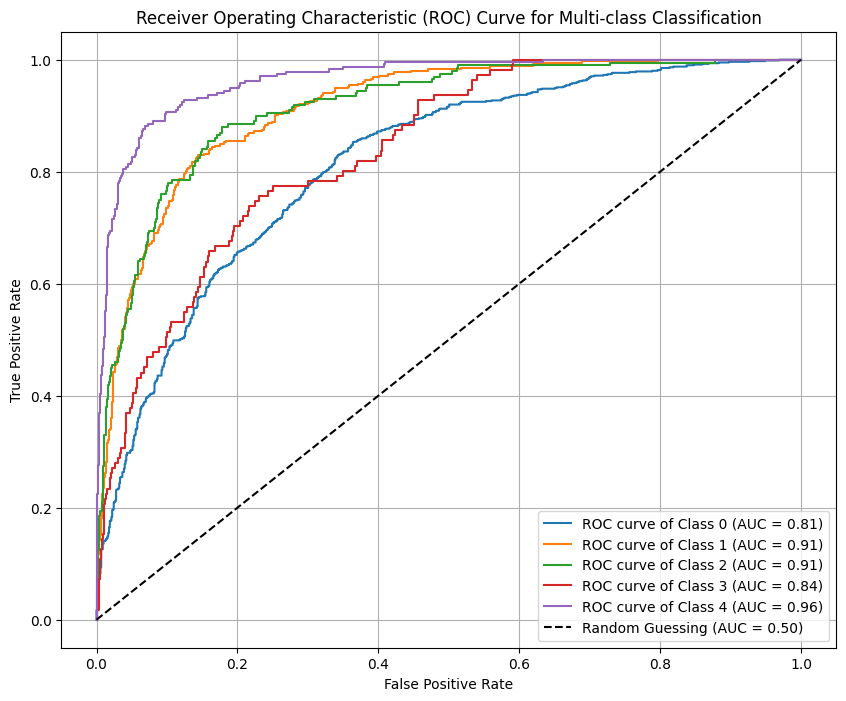

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels for multi-class ROC calculation
# Ensure y_test contains all unique labels to correctly binarize
num_classes = len(np.unique(y_test))
if num_classes > 2: # For multiclass, binarize labels
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))
else: # For binary classification, use original labels directly or expand to 2 classes
    y_test_binarized = y_test # Assuming y_test is already 0 or 1
    if num_classes == 1: # Handle case where only one class is present in y_test_binarized
        print("Warning: Only one class present in y_test. ROC curve cannot be plotted.")
        # Optionally, you can skip plotting or handle this edge case differently.
        # For now, we'll proceed but the plot might be trivial or erroneous.
        if np.unique(y_test)[0] == 0:
            y_test_binarized = np.hstack((np.ones((len(y_test), 1)), np.zeros((len(y_test), 1))))
        else:
            y_test_binarized = np.hstack((np.zeros((len(y_test), 1)), np.ones((len(y_test), 1))))
        num_classes = 2 # Adjust num_classes for plotting logic

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(num_classes):
    if num_classes > 2:
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], classification_probabilities[:, i])
    else:
        # For binary, if y_test_binarized is 1D, roc_curve expects positive class probabilities
        # y_test_binarized should be 0 or 1, classification_probabilities[:, 1] for positive class
        fpr, tpr, _ = roc_curve(y_test, classification_probabilities[:, 1]) # Assuming class 1 is the positive class
        # Only plot once for binary case, as 'i' might just be 0
        if i > 0: # Skip if it's the second iteration in binary, already plotted
            continue

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Interpretation of ROC Curve Visualization

**Reasoning**:
This section provides an interpretation of the generated ROC curve plot, explaining what the curves and AUC values signify for the model's performance in distinguishing between classes.

**Interpretation**:

The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The Area Under the Curve (AUC) provides an aggregate measure of performance across all possible classification thresholds.

*   **Higher and Steeper Curves:** A curve that is closer to the top-left corner indicates better performance. This means the model achieves a high TPR (correctly identifies positive instances) while maintaining a low FPR (minimizing false alarms).
*   **AUC Values:**
    *   An AUC of 1.0 indicates a perfect classifier.
    *   An AUC of 0.5 indicates a classifier that performs no better than random guessing (represented by the dashed diagonal line).
    *   AUC values between 0.5 and 1.0 suggest varying degrees of better-than-random performance.

From the generated plot, you can:

*   **Compare Class Performance:** Observe which classes have ROC curves closer to the top-left corner and higher AUC values. These are the classes that the model distinguishes most effectively from the other classes.
*   **Identify Weaknesses:** If any class has an ROC curve close to the diagonal line or a low AUC, it indicates that the model struggles to differentiate that class from others. This could be due to data imbalance, overlapping features, or the inherent difficulty of the classification task for that specific class.

This visualization complements the confusion matrix by providing a threshold-independent measure of discriminative power for each class, which is particularly useful in multi-class scenarios.
